# Análisis Exploratorio

    Fuente de información: NUSE
    Archivos: 
    NUSE 934 611(M) 2017-2018.dsv
    NUSE 934-611-611M ENERO2019.csv

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import calendar
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)  
from wordcloud import WordCloud, STOPWORDS
import folium
from folium import plugins
import geopandas as gpd

# Methods to visualize analysis results

In [2]:
#Create folder to save figures
import os

if not os.path.exists("figuras_nuse"):
    os.mkdir("figuras_nuse")

In [3]:
def print_Data(df):
    if len(df)>10:
        topdata=(df.sort_values(by=['Frecuencia'],ascending=False)[:5])
        taildata = (df.sort_values(by=['Frecuencia'],ascending=True)[:5])
        print("Top values")
        display(topdata.style.hide_index())
        print("Bottom values")
        display(taildata.style.hide_index())
    else:
        display(df.style.hide_index())

In [4]:
def basic_Description(df):
    print_Data(df)
    print("Statistics")
    display(pd.DataFrame(df.describe()))
    sns.boxplot(y=df['Frecuencia'])

In [5]:
def create_Subdata(df,variables_array):
    subdata=pd.DataFrame(df.groupby(variables_array).size(),columns=["Frecuencia"]).sort_index().reset_index()
    return subdata

In [6]:
def normalize_subdata(subdata, years_array):
    subdata['Factor normalizacion']= subdata.apply (lambda row: norm_factor_localidad(row['COD_LOCALIDAD'],years_array), axis=1)
    subdata['Frecuencia']= subdata['Frecuencia']*subdata['Factor normalizacion']
    subdata.drop(columns=['Factor normalizacion'],inplace=True)
    subdata.drop([0, 19], inplace=True) #drop sin localización
    return subdata


def norm_factor_localidad(cod_localidad,years_array):
    num_inhabitants = 10000
    if cod_localidad != 99:
        population_values =[]
        for year in years_array:
            value = poblacion_localidades.at[cod_localidad,year]
            population_values.append(int(value.strip().replace(',','')))
        
        mean_population = int(sum(population_values)/len(population_values))
        norm_factor = num_inhabitants / mean_population
        
        return norm_factor
    else:
        return 1

In [7]:
def bar_figure_top_values(df,variable,fig_name):
    if len(df)>22:
        topdata=(df.sort_values(by=['Frecuencia'],ascending=False)[:10])
    else:
        topdata=df.sort_values(by=['Frecuencia'],ascending=False)
        
    fig = px.bar(topdata, x='Frecuencia', y=variable, orientation='h', color = variable, 
             color_discrete_sequence = px.colors.qualitative.Prism[2:])
    fig.update_layout(yaxis={"type":"category"}, showlegend=False)
    file_path = "figuras_nuse/"+fig_name
    if fig_name != '':
        fig.write_image(file_path)
    fig.show()

In [8]:
def line_figure(df,x_var,min_values,max_values,fig_name):
    fig = px.line(df, x=x_var, y='Frecuencia', color_discrete_sequence = px.colors.qualitative.Prism[1:])
    fig.update_xaxes(title=x_var)
    fig.update_yaxes(title='Frecuencia')
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
              x=i[0],
              y=i[1],
              xref="x",
              yref="y",
              showarrow=False,
              text=str(i[0])+" : "+str(i[1]),
              font=dict(
                  family="Courier New, monospace",
                  size=16,
                  color="black"
              ),
          ) for i in df.sort_values('Frecuencia').head(min_values).append(df.sort_values('Frecuencia').tail(max_values))[[x_var,'Frecuencia']].values
        ]
    )
    file_path = "figuras_nuse/"+fig_name
    if fig_name != '':
        fig.write_image(file_path,width=1000,height=500)
    fig.show()
    print("Promedio: ",df.mean())
    print("Desviación estandar: ",df.std())

In [9]:
def bar_figure_probabilities(df,variable,values_order,media_factor,fig_name):
    df['Porcentaje']=df['Frecuencia']/df['Frecuencia'].sum()*100
    fig=px.bar(df,x='Porcentaje',color=variable,y=variable,orientation='h',
               category_orders={variable: values_order},
               color_discrete_sequence = px.colors.qualitative.Prism[1:])
    fig.update(layout_showlegend=False)

    fig.add_trace(go.Scatter(
        x=[df.Porcentaje.mean()]*2,
        y=[values_order[0],values_order[-1]],
        text=['Media='+str(round(df.Frecuencia.mean()/media_factor,2)),
              ''
              ],
        line=dict(color='black', width=2),
        mode="text+lines",
    ))
    fig.add_trace(go.Scatter(
        x=[df.Porcentaje.mean()+df.Porcentaje.std()]*2,
        y=[values_order[0],values_order[-1]],
        text=['',
              'std='+str(round(df.Frecuencia.std()/media_factor,2)),
              ],
        line=dict(color='black', width=2,
                                  dash='dash'),
        mode="text+lines",
    ))
    fig.add_trace(go.Scatter(
        x=[df.Porcentaje.mean()-df.Porcentaje.std()]*2,
        y=[values_order[0],values_order[-1]],
        text=['',
              'std='+str(round(df.Frecuencia.std()/media_factor,2)),
              ],
        line=dict(color='black', width=2,
                                  dash='dash'),
        mode="text+lines",
    ))
    file_path = "figuras_nuse/"+fig_name
    if fig_name != '':
        fig.write_image(file_path,width=1000,height=500)
    fig.show()

In [10]:
def bubbles_figure_probabilities(df,var1,var2,var1_order,var2_order,fig_name):
    df['Porcentaje']=df['Frecuencia']/df['Frecuencia'].sum()*100
    fig = px.scatter(df, x=var1, y="Porcentaje", size="Porcentaje", color=var2,
                     width=1000, height=600, color_discrete_sequence = px.colors.qualitative.Prism[1:],
                     category_orders={var2: var2_order}, hover_name=var2, size_max=40)
    fig.update_xaxes(tickangle=0,categoryorder="array", categoryarray=var1_order)
    if len(df[var1].unique()) > 10:
        fig.update_xaxes(tickangle=90)
    file_path = "figuras_nuse/"+fig_name
    if fig_name != '':
        fig.write_image(file_path,width=1000,height=500)
    fig.show()

In [11]:
def table_figure_probabilities(df,var1,var2,var1_order,var2_order,var_aux,fig_name):
    A=df.groupby([var1,var2]).agg({var_aux:'count'}).reset_index().rename(columns={var_aux:'Frecuencia'})
    A['Porcentaje']=A['Frecuencia']/A['Frecuencia'].sum()
    join=(A.pivot(var1,var2,'Porcentaje')).fillna(0)
    if len(var2_order) > 0:
        join = join.reindex(var2_order, axis=1)
    if len(var1_order) > 0:
        join = join.reindex(var1_order)
    gc=join/join.sum(axis=0)
    gf=(join.T/join.sum(axis=1)).T
    M=[join,gc,gf]
    title=["join",'g_columna',"g_fila"]

    for k in range(3):
     print(title[k])
     fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
     fig.set_size_inches(7, 6)
     g=sns.heatmap(M[k],vmin=0, vmax=0.4,annot=True,fmt=".1%",linewidths=0,cmap="Blues",cbar=False)
     g.set_yticklabels(g.get_yticklabels(), rotation = 0)
     bottom, top = ax.get_ylim()
     ax.set_ylim(bottom + 0.5, top - 0.5)
     if k == 1:
       ax.vlines(np.arange(20), *ax.get_ylim())
     if k == 2:
       ax.hlines(np.arange(20), *ax.get_xlim())
     
     file_path = "figuras_nuse/"+fig_name
     plt.savefig(file_path+title[k],dpi=300,bbox_inches = "tight")
     plt.show()

In [12]:
def custom_heatmap(df, lat_col='latitude', lon_col='longitude', zoom_start=11, \
                plot_points=False, pt_radius=15, \
                draw_heatmap=False, heat_map_weights_col=None, \
                heat_map_weights_normalize=True, heat_map_radius=15):
    """Creates a map given a dataframe of points. Can also produce a heatmap overlay

    Arg:
        df: dataframe containing points to maps
        lat_col: Column containing latitude (string)
        lon_col: Column containing longitude (string)
        zoom_start: Integer representing the initial zoom of the map
        plot_points: Add points to map (boolean)
        pt_radius: Size of each point
        draw_heatmap: Add heatmap to map (boolean)
        heat_map_weights_col: Column containing heatmap weights
        heat_map_weights_normalize: Normalize heatmap weights (boolean)
        heat_map_radius: Size of heatmap point

    Returns:
        folium map object
    """

    ## center map in the middle of points center in
    middle_lat = df[lat_col].median()
    middle_lon = df[lon_col].median()

    curr_map = folium.Map(location=[middle_lat, middle_lon],
                          zoom_start=zoom_start)

    # add points to map
    if plot_points:
        for _, row in df.iterrows():
            folium.CircleMarker([row[lat_col], row[lon_col]],
                                radius=pt_radius,
                                #popup=row['name'],
                                fill_color="#3db7e4", # divvy color
                               ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        # convert to (n, 2) or (n, 3) matrix format
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            # if we have to normalize
            if heat_map_weights_normalize:
                df[heat_map_weights_col] = \
                    df[heat_map_weights_col] / df[heat_map_weights_col].sum()

            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]

        subdata = df[cols_to_pull].values
        curr_map.add_child(plugins.HeatMap(subdata, radius=heat_map_radius))

    return curr_map

In [13]:
def map_localidad(ax,df,col_localidad,col_vals,vmin=None,vmax=None):
  loc_geo="/Users/anamaria/Desktop/dev/security_project/assets/loca.geojson.json"
  loc_=gpd.read_file(loc_geo)
  loc_=loc_.merge(df,left_on='LocNombre',right_on=col_localidad)
  loc_.plot(cmap='viridis',column=col_vals,legend=True,ax=ax,vmin=vmin,vmax=vmax)  

# Load datasets

In [14]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/NUSE 934 611(M) 2017-2018.dsv'
data2018=pd.read_csv(data_location,delimiter="|")

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.



In [15]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/NUSE 934-611-611M ENERO2019.csv'
data2019=pd.read_csv(data_location,delimiter=";")

## Join datasets

In [16]:
frames = [data2018, data2019]
data = pd.concat(frames)

## Assets

In [17]:
data_location = '/Users/anamaria/Desktop/dev/security_project/assets/poblacion_localidades.csv'
poblacion_localidades=pd.read_csv(data_location,delimiter=",")

In [18]:
poblacion_localidades['Cod Localidad'].astype(int)
poblacion_localidades.set_index('Cod Localidad', inplace=True)

# Basic dataset description

In [ ]:
data.head()

In [ ]:
print("Tamaño:",data.shape)
print("size: ",data.size)
print("Porcentaje Celdas Vacias:",data.isna().mean().mean())
print("Porcentaje Celdas con valor '-':",(data == "-").mean().mean())
print("Filas duplicadas",data.duplicated().sum())

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
print("Tamaño:",data.shape)
print("size: ",data.size)
print("Porcentaje Celdas Vacias:",data.isna().mean().mean())
print("Porcentaje Celdas con valor '-':",(data == "-").mean().mean())
print("Filas duplicadas",data.duplicated().sum())

In [ ]:
pd.DataFrame({"Tipo de dato":data.dtypes.values,
              "Celdas con valor '-'":(data == '-').sum().values,
              "Celdas vacías": data.isna().sum().values},
             index=data.columns)

# Create aditional variables or convert to another format

In [19]:
# Fecha to datetime
data['FECHA'] =  pd.to_datetime(data['FECHA'])
data2018['FECHA'] =  pd.to_datetime(data2018['FECHA'])

#Day of week
data['day_of_week'] = data["FECHA"].dt.day_name()
data2018['day_of_week'] = data2018["FECHA"].dt.day_name()
weeks_between = round((data["FECHA"].max()-data["FECHA"].min())/np.timedelta64(1,'W'))

#Format 'HORA' field into datetime to proper visualization
data['time_stamp']=pd.to_datetime(data["HORA"].astype(str).str.rjust(4,'0'),format= '%H%M').dt.time

In [20]:
#DIA_EXTENDIDO for all dataset
data['DIA_EXTENDIDO'] = data['day_of_week']
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Monday'), 'DIA_EXTENDIDO'] = 'Sunday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Tuesday'), 'DIA_EXTENDIDO'] = 'Monday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Wednesday'), 'DIA_EXTENDIDO'] = 'Tuesday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Thursday'), 'DIA_EXTENDIDO'] = 'Wednesday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Friday'), 'DIA_EXTENDIDO'] = 'Thursday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Saturday'), 'DIA_EXTENDIDO'] = 'Friday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Sunday'), 'DIA_EXTENDIDO'] = 'Saturday'

In [21]:
#DIA_EXTENDIDO just for 2017 and 2018 data
data2018['DIA_EXTENDIDO'] = data2018['day_of_week']
data2018.loc[(data2018.HORA >= 0) & (data2018.HORA <= 359) & (data2018.day_of_week == 'Monday'), 'DIA_EXTENDIDO'] = 'Sunday'
data2018.loc[(data2018.HORA >= 0) & (data2018.HORA <= 359) & (data2018.day_of_week == 'Tuesday'), 'DIA_EXTENDIDO'] = 'Monday'
data2018.loc[(data2018.HORA >= 0) & (data2018.HORA <= 359) & (data2018.day_of_week == 'Wednesday'), 'DIA_EXTENDIDO'] = 'Tuesday'
data2018.loc[(data2018.HORA >= 0) & (data2018.HORA <= 359) & (data2018.day_of_week == 'Thursday'), 'DIA_EXTENDIDO'] = 'Wednesday'
data2018.loc[(data2018.HORA >= 0) & (data2018.HORA <= 359) & (data2018.day_of_week == 'Friday'), 'DIA_EXTENDIDO'] = 'Thursday'
data2018.loc[(data2018.HORA >= 0) & (data2018.HORA <= 359) & (data2018.day_of_week == 'Saturday'), 'DIA_EXTENDIDO'] = 'Friday'
data2018.loc[(data2018.HORA >= 0) & (data2018.HORA <= 359) & (data2018.day_of_week == 'Sunday'), 'DIA_EXTENDIDO'] = 'Saturday'

In [22]:
#RANGO_HORA each 4 hours
data.loc[(data.HORA >= 0) & (data.HORA <= 359), 'RANGO_HORA'] = '0:00 a 3:59'
data.loc[(data.HORA >= 400) & (data.HORA <= 759), 'RANGO_HORA'] = '4:00 a 7:59'
data.loc[(data.HORA >= 800) & (data.HORA <= 1159), 'RANGO_HORA'] = '8:00 a 11:59'
data.loc[(data.HORA >= 1200) & (data.HORA <= 1559), 'RANGO_HORA'] = '12:00 a 15:59'
data.loc[(data.HORA >= 1600) & (data.HORA <= 1959), 'RANGO_HORA'] = '16:00 a 19:59'
data.loc[(data.HORA >= 2000) & (data.HORA <= 2359), 'RANGO_HORA'] = '20:00 a 23:59'

In [23]:
#Select just de data we care
data = data.query('TIPO_DETALLE == "934 - RIÑA"')
data2018 = data2018.query('TIPO_DETALLE == "934 - RIÑA"')

# Análisis univariado

### Analisis campo 'FECHA'

In [ ]:
subdata = create_Subdata(data,["FECHA"])
basic_Description(subdata)

In [ ]:
bar_figure_top_values(subdata,variable='FECHA',fig_name="riñas_nuse_fecha_frecuencias.png")

In [ ]:
line_figure(subdata,x_var='FECHA',min_values=1,max_values=4,fig_name="riñas_nuse_fecha_serie_tiempo.png")

### Analisis variable aux 'day_of_week'

In [ ]:
subdata = create_Subdata(data,["day_of_week"])
basic_Description(subdata)

In [ ]:
values_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
media_factor = weeks_between
bar_figure_probabilities(subdata,'day_of_week',values_order,media_factor,fig_name="riñas_nuse_dia_probabilidad.png")

### Analisis variable aux 'DIA_EXTENDIDO'

In [ ]:
subdata = create_Subdata(data,["DIA_EXTENDIDO"])
basic_Description(subdata)

In [ ]:
values_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
media_factor = weeks_between
bar_figure_probabilities(subdata,'DIA_EXTENDIDO',values_order,media_factor,fig_name="riñas_nuse_dia_extendido_probabilidad.png")

### Análisis campo 'HORA'

In [ ]:
subdata = create_Subdata(data,["HORA"])
basic_Description(subdata)

In [ ]:
bar_figure_top_values(subdata,variable='HORA',fig_name="riñas_nuse_hora_frecuencias.png")

### Análisis campo 'time_stamp'

In [ ]:
subdata = create_Subdata(data,["time_stamp"])
line_figure(subdata,x_var='time_stamp',min_values=1,max_values=1,fig_name="riñas_nuse_hora_serie_tiempo.png")

### Análisis campo 'ANIO'

In [ ]:
subdata = create_Subdata(data,["ANIO"])
basic_Description(subdata)

In [ ]:
subdata['ANIO']=subdata["ANIO"].astype(str)
bar_figure_top_values(subdata,variable='ANIO',fig_name="riñas_nuse_año_frecuencias.png")

### Análisis campo 'MES'

In [ ]:
subdata = create_Subdata(data2018,["MES"])
basic_Description(subdata)

In [ ]:
subdata['MES']=subdata["MES"].astype(str)
bar_figure_top_values(subdata,variable='MES',fig_name="riñas_nuse_mes_frecuencias.png")

In [ ]:
values_order = ["1","2","3","4","5","6","7","8","9","10","11","12"]
media_factor = 2
bar_figure_probabilities(subdata,'MES',values_order,media_factor,fig_name="riñas_nuse_mes_probabilidad.png")

### Análisis campo 'PERIODO_TS'

In [ ]:
subdata = create_Subdata(data,["PERIODO_TS"])
basic_Description(subdata)

In [ ]:
bar_figure_top_values(subdata,variable='PERIODO_TS',fig_name="riñas_nuse_periodo_frecuencias.png")

### Análisis campo 'COD_LOCALIDAD' y 'LOCALIDAD'

In [ ]:
subdata = create_Subdata(data,["COD_LOCALIDAD","LOCALIDAD"])
basic_Description(subdata)

In [ ]:
bar_figure_top_values(subdata,variable='LOCALIDAD',fig_name="riñas_nuse_localidad_frecuencias.png")

In [ ]:
values_order = []
media_factor = 1
bar_figure_probabilities(subdata,'LOCALIDAD',values_order,media_factor,fig_name="riñas_nuse_localidad_probabilidad.png")

### Análisis campo 'LOCALIDAD' normalizado por tamaño población

Top values


COD_LOCALIDAD,LOCALIDAD,Frecuencia
8,KENNEDY,150913
11,SUBA,150038
10,ENGATIVA,107755
19,CIUDAD BOLIVAR,101061
7,BOSA,99961


Bottom values


COD_LOCALIDAD,LOCALIDAD,Frecuencia
99,SIN LOCALIZACION,2473
17,CANDELARIA,5541
15,ANTONIO NARIÑO,17405
13,TEUSAQUILLO,21104
14,LOS MARTIRES,22002


Statistics


,COD_LOCALIDAD,Frecuencia
count,20.000000,20.000000
mean,14.450000,55441.750000
std,20.640979,44655.363029
min,1.000000,2473.000000
25%,5.750000,23185.500000
50%,10.500000,40906.000000
75%,15.250000,74173.000000
max,99.000000,150913.000000


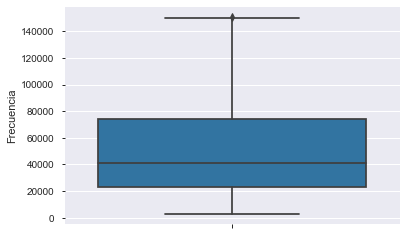

In [24]:
subdata = create_Subdata(data,["COD_LOCALIDAD","LOCALIDAD"])
basic_Description(subdata)

In [25]:
years_array = ['2017','2018','2019']
normalize_subdata(subdata,years_array)

,COD_LOCALIDAD,LOCALIDAD,Frecuencia
1,2,CHAPINERO,2390.927031
2,3,SANTA FE,2512.546751
3,4,SAN CRISTOBAL,1641.592762
4,5,USME,1428.042343
5,6,TUNJUELITO,1523.086416
6,7,BOSA,1326.384788
7,8,KENNEDY,1226.425444
8,9,FONTIBON,1058.758890
9,10,ENGATIVA,1220.034125
10,11,SUBA,1140.436555


In [ ]:
bar_figure_top_values(subdata,variable='LOCALIDAD',fig_name="riñas_nuse_localidad_normalizada_frecuencias.png")

In [ ]:
values_order = []
media_factor = 1
bar_figure_probabilities(subdata,'LOCALIDAD',values_order,media_factor,fig_name="riñas_nuse_localidad_normalizada_probabilidad.png")

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
map_localidad(ax,subdata,'LOCALIDAD','Porcentaje',2,10)
ax.axis('off')
#ax.set_title(fecha)
plt.savefig("figuras_nuse/riñas_nuse_localidad_normalizada_probabilidad_mapa.png",dpi=300,bbox_inches = "tight")
plt.show()

### Análisis campo 'COD_UPZ' y 'UPZ'

In [ ]:
subdata = create_Subdata(data,["COD_UPZ","UPZ"])
basic_Description(subdata)

In [ ]:
bar_figure_top_values(subdata,variable='UPZ',fig_name="riñas_nuse_upz_frecuencias.png")

### Análisis campos 'COD_SEC_CATAST‘ y ‘SEC_CATASTRAL'

In [ ]:
subdata = create_Subdata(data,["COD_SEC_CATAST","SEC_CATASTRAL"])
basic_Description(subdata)

In [ ]:
bar_figure_top_values(subdata,variable='SEC_CATASTRAL',fig_name="riñas_nuse_sec_catastral_frecuencias.png")

### Análisis campos 'COD_BARRIO' Y 'BARRIO'

In [ ]:
subdata = create_Subdata(data,["COD_BARRIO","BARRIO"])
basic_Description(subdata)

In [ ]:
bar_figure_top_values(subdata,variable='BARRIO',fig_name="riñas_nuse_barrio_frecuencias.png")

### Análisis campos (LATITUD, LONGITUD)

In [ ]:
subdata = create_Subdata(data,["LATITUD","LONGITUD"])
basic_Description(subdata)

### Mapa de calor

In [ ]:
mapa_riñas = custom_heatmap(subdata, lat_col='LATITUD',lon_col='LONGITUD',plot_points=False, draw_heatmap=True, 
           heat_map_weights_normalize=True,heat_map_weights_col='Frecuencia',heat_map_radius=14)
mapa_riñas.save("figuras_nuse/riñas_nuse_coordenadas_mapa.html")
mapa_riñas

### Análisis campo 'STR_DIRECCION_INCIDENTE'

In [ ]:
subdata = create_Subdata(data,["STR_DIRECCION_INCIDENTE"])
basic_Description(subdata)

In [ ]:
bar_figure_top_values(subdata,variable='STR_DIRECCION_INCIDENTE',fig_name="riñas_nuse_direccion_frecuencias.png")

### Análisis campo 'ESTADO_INCIDENTE'

In [ ]:
subdata = create_Subdata(data,["ESTADO_INCIDENTE"])
basic_Description(subdata)

In [ ]:
bar_figure_top_values(subdata,variable='ESTADO_INCIDENTE',fig_name="riñas_nuse_estado_incidente_frecuencias.png")

### Análisis campo 'LOG_TEXT'

In [ ]:
text = ' '.join(data['LOG_TEXT'].str.lower())

stopwords = set(STOPWORDS)
stopwords.update(['de','la','el','que','y','con','en'])

In [ ]:
wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black',stopwords = stopwords, max_words=1000).generate(text)
fig = plt.figure(figsize = (20, 10),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("figuras_nuse/log_text",dpi=300,bbox_inches = "tight")
plt.show()

In [ ]:
## Add labels to stopwords
stopwords.update(['direction','messsageid','outgoing','origorganisation','originincidentturn',
                  'originincidentdate','originincidenttime','callorigin priority','location','easting',
                 'callernumber','callerforename','callorigin','alta','prioridad','nuse','origin',
                 'incaddnlinfo','incsecurity', 'northing','type','description','messageid origincidenturn',
                 'origincidenttime priority','priority','originincidentturn originincidentdate',
                 'originincidentdate originincidenttime'])


In [ ]:
wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black',stopwords = stopwords, max_words=1000).generate(text)
fig = plt.figure(figsize = (20, 10),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("figuras_nuse/log_text2",dpi=300,bbox_inches = "tight")
plt.show()

# ANÁLISIS BIVARIADO

## 'HORA' y día de la semana

In [ ]:
subdata=pd.DataFrame(data.groupby(["time_stamp","day_of_week"]).size(),columns=["Cantidad"]).sort_index().reset_index()

fig = px.line(subdata, x="time_stamp", y="Cantidad", facet_row="day_of_week", color="day_of_week",
              width=800, height=1400,  color_discrete_sequence = px.colors.qualitative.Prism[1:],
              category_orders={"day_of_week": ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]},
              labels={"day_of_week":"day"})
fig.update_layout(title_text="",
                 showlegend=False)
fig.write_image("figuras_nuse/riñas_nuse_dia_hora_ts.png")
fig.show()

## Rango hora y día de la semana

In [ ]:
subdata = create_Subdata(data,['RANGO_HORA','day_of_week'])

In [ ]:
#Probabilidad conjunta
var1='RANGO_HORA'
var2='day_of_week'
var1_order = ["0:00 a 3:59","4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59"]
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_rango_hora_dia_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='RANGO_HORA'
var2='day_of_week'
var_aux='STR_NUMERO_INTERNO'
var1_order = ["0:00 a 3:59","4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59"]
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_rango_hora_dia_condicional_")

## Rango hora y día de la semana extendido

In [ ]:
subdata = create_Subdata(data,['RANGO_HORA','DIA_EXTENDIDO'])

In [ ]:
#Probabilidad conjunta
var1='RANGO_HORA'
var2='DIA_EXTENDIDO'
var1_order = ["0:00 a 3:59","4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59"]
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_rango_hora_dia_extendido_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='RANGO_HORA'
var2='DIA_EXTENDIDO'
var_aux='STR_NUMERO_INTERNO'
var1_order = ["4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59","0:00 a 3:59"]
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_rango_hora_dia_extendido_condicional_")

## Mes y día de la semana

In [ ]:
subdata = create_Subdata(data,['MES','day_of_week'])

In [ ]:
#Probabilidad conjunta
var1='MES'
var2='day_of_week'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_mes_dia_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='MES'
var2='day_of_week'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_mes_dia_condicional_")

## Mes y día de la semana extendido

In [ ]:
subdata = create_Subdata(data,['MES','DIA_EXTENDIDO'])

In [ ]:
#Probabilidad conjunta
var1='MES'
var2='DIA_EXTENDIDO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_mes_dia_extendido_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='MES'
var2='DIA_EXTENDIDO'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_mes_dia_extendido_condicional_")

## Mes y año

In [ ]:
subdata = create_Subdata(data2018,['MES','ANIO'])

In [ ]:
#Probabilidad conjunta
var1='MES'
var2='ANIO'
var1_order = []
var2_order = []
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_mes_año_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='ANIO'
var2='MES'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = []
table_figure_probabilities(data2018,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_mes_año_condicional_")

## Localidades y rango hora

In [ ]:
subdata = create_Subdata(data,['LOCALIDAD','RANGO_HORA'])

In [ ]:
#Probabilidad conjunta
var1='LOCALIDAD'
var2='RANGO_HORA'
var1_order = []
var2_order = ["0:00 a 3:59","4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_localidad_rango_hora_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='LOCALIDAD'
var2='RANGO_HORA'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = ["0:00 a 3:59","4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_localidad_rango_hora_condicional_")

## Localidades y día de la semana

In [ ]:
subdata = create_Subdata(data,['LOCALIDAD','day_of_week'])

In [ ]:
#Probabilidad conjunta
var1='LOCALIDAD'
var2='day_of_week'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_localidad_dia_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='LOCALIDAD'
var2='day_of_week'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_localidad_dia_condicional_")

## Localidades y día extendido

In [ ]:
subdata = create_Subdata(data,['LOCALIDAD','DIA_EXTENDIDO'])

In [ ]:
#Probabilidad conjunta
var1='LOCALIDAD'
var2='DIA_EXTENDIDO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_localidad_dia_extendido_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='LOCALIDAD'
var2='DIA_EXTENDIDO'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_localidad_dia_extendido_condicional_")

## Localidades y mes

In [ ]:
subdata = create_Subdata(data,['LOCALIDAD','MES'])

In [ ]:
#Probabilidad conjunta
var1='LOCALIDAD'
var2='MES'
var1_order = []
var2_order = []
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_localidad_mes_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='LOCALIDAD'
var2='MES'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = []
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_localidad_mes_condicional_")